# HJB Optimal Control for Insurance Program Optimization

## A Teaching Guide: From Ergodic Theory to State-Dependent Insurance Decisions

This notebook teaches **Hamilton-Jacobi-Bellman (HJB) optimal control** applied to multi-layered insurance program design. It is written for junior actuaries, risk managers, and CFOs who want to understand *why* insurance premiums exceeding expected losses can still be optimal and how to compute the best possible insurance strategy.

### What we will do

- Optimize a **4-layer insurance program** for a **$25M manufacturing company** over a **25-year horizon**
- Use **Common Random Numbers (CRN)** to fairly compare strategies under identical loss scenarios
- Compare **HJB feedback control** (state-dependent) against traditional static strategies
- Explore how loss assumptions affect optimal strategy through **sensitivity analysis**
- Quantify the **cost of getting it wrong** -- why under-insuring is far more dangerous than over-insuring
- Validate results with **walk-forward out-of-sample testing**

### Prerequisites

- Basic probability and statistics
- Insurance concepts: retention (deductible), limits, layers, attachment points
- Familiarity with Python and NumPy is helpful but not strictly required

### Estimated runtime

15-30 minutes on Google Colab.

---

### Table of Contents

1. [Why Insurance Optimization Needs Optimal Control](#part1)
2. [Our Manufacturing Company](#part2)
3. [The 4-Layer Insurance Program](#part3)
4. [The Ergodic Insight -- Why Expected Value Misleads](#part4)
5. [How Insurance Fixes This](#part5)
6. [Introduction to HJB Optimal Control](#part6)
7. [Visualizing the Optimal Policy](#part7)
8. [25-Year Monte Carlo Strategy Comparison](#part8)
9. [Sensitivity Analysis -- How Loss Assumptions Drive Strategy](#part9)
10. [Walk-Forward Validation](#part10)
11. [The Cost of Getting It Wrong](#part11)
12. [Key Takeaways for the Junior Actuary](#takeaways)
13. [Next Steps](#next-steps)

In [1]:
"""Google Colab setup: mount Drive and install package dependencies.

Run this cell first. If prompted to restart the runtime, do so, then re-run all cells.
This cell is a no-op when running locally.
"""
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    NOTEBOOK_DIR = '/content/drive/My Drive/Colab Notebooks/ei_notebooks/optimization'

    os.chdir(NOTEBOOK_DIR)
    if NOTEBOOK_DIR not in sys.path:
        sys.path.append(NOTEBOOK_DIR)

    !pip install ergodic-insurance -q 2>&1 | tail -3
    print('\nSetup complete. If you see numpy/scipy import errors below,')
    print('restart the runtime (Runtime > Restart runtime) and re-run all cells.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Setup complete. If you see numpy/scipy import errors below,
restart the runtime (Runtime > Restart runtime) and re-run all cells.


<a id="part1"></a>
## Part 1: Why Insurance Optimization Needs Optimal Control

### The insurance buyer's dilemma

You are the CFO of a mid-size manufacturer. Every year you face the same question: *how much insurance should we buy?* You have a premium budget, multiple layers to fill (primary, excess, catastrophic), and the wrong choice compounds over decades.

### The traditional approach and its flaw

The traditional actuarial approach picks retentions and limits based on **expected loss**. You calculate the expected annual loss, add a margin, and buy coverage accordingly. But there is a subtle, critical flaw:

> **Expected loss is not the same as time-average cost.**

Expected loss is an *ensemble average* -- the average over many hypothetical companies in parallel. But your company is not an ensemble. It is a single entity that must survive *sequentially through time*. The time-average cost can be dramatically different from the expected cost.

### Key insight preview

By the end of this notebook, you will see that **a policy costing 3x expected losses can still be optimal over 25 years**. This is not a paradox -- it is the consequence of the **multiplicative nature of wealth**: losses don't just subtract from your balance sheet, they compound through reduced reinvestment, missed opportunities, and increased borrowing costs.

The HJB equation gives us a principled mathematical framework for finding the *globally optimal* insurance at every wealth level and time point.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from concurrent.futures import ProcessPoolExecutor
import warnings
import logging
import time

# Suppress all warnings and verbose solver logging
warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)

from ergodic_insurance.hjb_solver import (
    StateVariable, ControlVariable, StateSpace,
    LogUtility, PowerUtility, ExpectedWealth,
    HJBProblem, HJBSolver, HJBSolverConfig,
)
from ergodic_insurance.optimal_control import (
    ControlSpace, StaticControl, HJBFeedbackControl,
    TimeVaryingControl, OptimalController,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = 40   # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

<a id="part2"></a>
## Part 2: Our Manufacturing Company

We model a vanilla manufacturing company with the following characteristics:

| Parameter | Value | Why it matters |
|---|---|---|
| Total assets | \$25M | Sets the scale of risk (a single large loss can be existential) |
| Asset turnover | 1.0x | Revenue = Assets, so \$25M annual revenue |
| Operating margin | 8% | \$2M/yr operating income (the "cushion" for absorbing losses) |
| Revenue volatility | 15% | Operational uncertainty via geometric Brownian motion |
| Tax rate | 25% | Tax shield reduces net cost of both premiums and retained losses |
| Earnings retention | 70% | 70% of after-tax profit reinvested for growth |
| Growth rate | 5% | Expected annual revenue growth |
| Time horizon | 25 years | Long enough for ergodic effects to dominate |

The key tension: this company earns only $2M/year in operating income, but faces potential losses in the millions or tens of millions. A single bad year can set it back by a decade.

In [ ]:
# --- Company Configuration ---
mfg_config = ManufacturerConfig(
    initial_assets=25_000_000,       # $25M total assets
    asset_turnover_ratio=1.5,        # Revenue = Assets × turnover = $37.5M
    base_operating_margin=0.12,      # 12% EBIT margin -> $4.5M/yr operating income
    tax_rate=0.25,                   # 25% corporate tax
    retention_ratio=0.70,            # 70% earnings retained for growth
)

# Display company profile
revenue = mfg_config.initial_assets * mfg_config.asset_turnover_ratio
ebit = revenue * mfg_config.base_operating_margin
print("=" * 60)
print("MANUFACTURING COMPANY PROFILE")
print("=" * 60)
print(f"Total Assets:          ${mfg_config.initial_assets:>14,.0f}")
print(f"Annual Revenue:        ${revenue:>14,.0f}")
print(f"Operating Income:      ${ebit:>14,.0f}")
print(f"Operating Margin:      {mfg_config.base_operating_margin:>13.1%}")
print(f"Asset Turnover:        {mfg_config.asset_turnover_ratio:>14.1f}x")
print(f"Revenue Volatility:    {'15.0%':>14s}")
print(f"Growth Rate:           {'5.0%':>14s}")
print(f"Tax Rate:              {mfg_config.tax_rate:>13.1%}")
print(f"Retention Ratio:       {mfg_config.retention_ratio:>13.1%}")
print("=" * 60)

<a id="part3"></a>
## Part 3: The 4-Layer Insurance Program

A realistic commercial insurance program is built in **layers** that stack on top of each other:

```
                                          $100M  +-------------------+
                                                 |  Layer 4: CAT     |
                                                 |  $50M xs $50M     |
                                                 |  Rate: 0.2%       |
                                          $50M   +-------------------+
                                                 |  Layer 3: 2nd Xs  |
                                                 |  $25M xs $25M     |
                                                 |  Rate: 0.4%       |
                                          $25M   +-------------------+
                                                 |  Layer 2: 1st Xs  |
                                                 |  $20M xs $5M      |
                                                 |  Rate: 0.8%       |
                                          $5M    +-------------------+
                                                 |  Layer 1: Primary |
                                                 |  $4.75M xs $250K  |
                                                 |  Rate: 1.5%       |
                                          $250K  +-------------------+
                                                 | Self-Insured      |
                                          $0     | Retention (SIR)   |
                                                 +-------------------+
```

How losses flow through the tower:

- **Losses below \$250K**: Company pays in full (self-insured retention)
- **Losses \$250K - \$5M**: Layer 1 (Primary) responds -- this is the "working layer" with frequent claims
- **Losses \$5M - \$25M**: Layer 2 (1st Excess) picks up the excess
- **Losses \$25M - \$50M**: Layer 3 (2nd Excess) -- infrequent severe losses
- **Losses \$50M - \$100M**: Layer 4 (Catastrophic) -- rare but devastating events
- **Losses above \$100M**: Uninsured -- company bears full exposure

The premium rate (rate-on-line) decreases as you go higher because the probability of reaching that layer drops dramatically.

In [ ]:
def create_insurance_program(retention_factor=1.0, limit_factor=1.0):
    """Create a 4-layer manufacturing insurance program.

    Args:
        retention_factor: Multiplier on all attachment points (for optimization).
        limit_factor: Multiplier on all limits (for optimization).
    """
    layers = [
        # Layer 1: Primary (working layer)
        EnhancedInsuranceLayer(
            attachment_point=250_000 * retention_factor,
            limit=(5_000_000 - 250_000) * limit_factor,
            base_premium_rate=0.38,   # 38% rate-on-line (working layer)
            reinstatements=0,
        ),
        # Layer 2: First Excess
        EnhancedInsuranceLayer(
            attachment_point=5_000_000 * retention_factor,
            limit=20_000_000 * limit_factor,
            base_premium_rate=0.015,  # 1.5% rate-on-line
            reinstatements=1,
        ),
        # Layer 3: Second Excess
        EnhancedInsuranceLayer(
            attachment_point=25_000_000 * retention_factor,
            limit=25_000_000 * limit_factor,
            base_premium_rate=0.005,  # 0.5% rate-on-line
            reinstatements=2,
        ),
        # Layer 4: Catastrophic
        EnhancedInsuranceLayer(
            attachment_point=50_000_000 * retention_factor,
            limit=50_000_000 * limit_factor,
            base_premium_rate=0.002,  # 0.2% rate-on-line
            reinstatements=999,        # Effectively unlimited
        ),
    ]
    return InsuranceProgram(
        layers=layers,
        deductible=250_000 * retention_factor,
        name="Manufacturing 4-Layer Program",
    )


# Create baseline program
program = create_insurance_program()
summary = program.get_program_summary()

print("4-LAYER INSURANCE PROGRAM")
print("=" * 70)
print(f"{'Layer':<12} {'Attachment':>12} {'Limit':>12} {'Exhaust Pt':>12} {'Premium':>10}")
print("-" * 70)
for i, layer_info in enumerate(summary['layers']):
    print(f"Layer {i+1:<5}  ${layer_info['attachment']:>11,.0f} ${layer_info['limit']:>11,.0f} "
          f"${layer_info['exhaustion_point']:>11,.0f} ${layer_info['base_premium']:>9,.0f}")
print("-" * 70)
print(f"{'TOTAL':<12} {'':>12} {'':>12} {'':>12} ${summary['annual_base_premium']:>9,.0f}")
print(f"\nDeductible: ${summary['deductible']:,.0f}")
print(f"Total Coverage: ${summary['total_coverage']:,.0f}")

### Shared Simulation Infrastructure

The cell below sets up three things used by every subsequent section:

1. **Amplified loss model** using the library's `ManufacturingLossGenerator` -- calibrated so the \$25M company faces ~\$1.5M in expected annual losses (75% of operating income), creating genuine existential risk.
2. **Common Random Numbers (CRN)** -- pre-generated loss scenarios at a fixed reference revenue. Every strategy faces the *same storms*; the only difference is how each ship is built. This eliminates noise from strategy comparisons.
3. **CRN simulation engine** -- processes pre-generated losses through the library's `InsuranceProgram.process_claim()`, so retained losses are calculated correctly by the insurance tower.

> **"Same storms, different ships."** By fixing the loss scenarios across strategies, even small differences in time-average growth become statistically significant. Without CRN, you would need 10x more paths to detect the same signal.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from concurrent.futures import ProcessPoolExecutor
import warnings
import logging
import time

# Suppress all warnings and verbose solver logging
warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)

from ergodic_insurance.hjb_solver import (
    StateVariable, ControlVariable, StateSpace,
    LogUtility, PowerUtility, ExpectedWealth,
    HJBProblem, HJBSolver, HJBSolverConfig,
)
from ergodic_insurance.optimal_control import (
    ControlSpace, StaticControl, HJBFeedbackControl,
    TimeVaryingControl, OptimalController,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = 40   # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

# =====================================================
# SHARED SIMULATION INFRASTRUCTURE
# =====================================================
# Used by Parts 5, 8, 9, 10, and 11.

# --- Economic Parameters ---
ATR = 1.5                # Asset turnover ratio
OPERATING_MARGIN = 0.12  # 12% EBIT margin
REV_VOL = 0.15           # Revenue volatility (annualized)
INITIAL_ASSETS = 25_000_000
REFERENCE_REVENUE = 25_000_000  # Fixed reference for loss calibration

# --- Amplified Loss Model ---
# Calibrated so expected annual aggregate loss is ~$1.5M
# (33% of the $4.5M operating income -- meaningful risk without insolvency)
LOSS_PARAMS = dict(
    attritional_params={'base_frequency': 5.0, 'severity_mean': 25_000, 'severity_cv': 1.5},
    large_params={'base_frequency': 0.5, 'severity_mean': 2_000_000, 'severity_cv': 2.0},
    catastrophic_params={'base_frequency': 0.05, 'severity_alpha': 2.5, 'severity_xm': 1_000_000},
)

# Quick validation of the loss model
_val_gen = ManufacturingLossGenerator(**LOSS_PARAMS, seed=99)
_val_totals = []
for _ in range(5000):
    _events, _stats = _val_gen.generate_losses(duration=1.0, revenue=REFERENCE_REVENUE)
    _val_totals.append(_stats['total_amount'])
_expected_annual_loss = np.mean(_val_totals)
_operating_income = INITIAL_ASSETS * ATR * OPERATING_MARGIN
print(f"Loss model validation (5,000 one-year samples):")
print(f"  Expected annual loss:  ${_expected_annual_loss:>12,.0f}")
print(f"  Operating income:      ${_operating_income:>12,.0f}")
print(f"  Loss / Income ratio:   {_expected_annual_loss / _operating_income:.0%}")
print(f"  Std dev annual loss:   ${np.std(_val_totals):>12,.0f}")
print(f"  Max annual loss:       ${np.max(_val_totals):>12,.0f}")
del _val_gen, _val_totals, _events, _stats


# --- Insurance Tower Factory ---
# Premium rates are calibrated so that buying more insurance (lower SIR)
# genuinely costs more in expected total cost.  This creates the
# economically meaningful tradeoff that the HJB solver exploits:
#   lower SIR  ->  lower variance  BUT  higher expected cost
#   higher SIR ->  higher variance  BUT  lower expected cost
#
# The primary (working) layer uses a 38% rate-on-line, reflecting
# realistic pricing for a layer that is expected to be penetrated
# in most years.  Excess layers carry progressively lower rates.

def make_program(sir: float) -> InsuranceProgram:
    """Create 4-layer tower with premium rates calibrated to the loss model.

    Args:
        sir: Self-insured retention (deductible).

    Returns:
        InsuranceProgram with realistic premium loading.
    """
    layer_defs = [
        # (base_attachment, ceiling, rate_on_line, reinstatements)
        (sir,        5_000_000,   0.38,  0),     # Primary: 38% ROL
        (5_000_000,  25_000_000,  0.015, 1),     # 1st Excess: 1.5% ROL
        (25_000_000, 50_000_000,  0.005, 2),     # 2nd Excess: 0.5% ROL
        (50_000_000, 100_000_000, 0.002, 999),   # Cat: 0.2% ROL
    ]
    layers = []
    for attach, ceiling, rate, reinst in layer_defs:
        effective_attach = max(attach, sir)
        limit = ceiling - effective_attach
        if limit <= 0:
            continue
        layers.append(EnhancedInsuranceLayer(
            attachment_point=effective_attach,
            limit=limit,
            base_premium_rate=rate,
            reinstatements=reinst,
        ))
    return InsuranceProgram(
        layers=layers,
        deductible=sir,
        name=f"Manufacturing Tower (SIR=${sir:,.0f})",
    )


# --- CRN: Pre-generate Loss Scenarios ---
def generate_loss_pool(n_paths, n_years, reference_revenue=REFERENCE_REVENUE, seed=SEED):
    """Pre-generate loss scenarios for Common Random Number comparison.

    All strategies will face the exact same loss events and revenue shocks.
    Losses are generated at a fixed reference revenue so that the
    loss distribution is constant across strategies -- only the insurance
    response differs.
    """
    ss = np.random.SeedSequence(seed)
    children = ss.spawn(n_paths + 1)

    # Shared revenue shocks
    rev_rng = np.random.default_rng(children[0])
    revenue_shocks = rev_rng.standard_normal((n_paths, n_years))

    # Per-path loss event sequences
    all_losses = []  # [path][year] -> List[LossEvent]
    for i in range(n_paths):
        gen = ManufacturingLossGenerator(
            **LOSS_PARAMS,
            seed=int(children[i + 1].generate_state(1)[0] % (2**31)),
        )
        path_losses = []
        for t in range(n_years):
            events, _ = gen.generate_losses(duration=1.0, revenue=reference_revenue)
            path_losses.append(events)
        all_losses.append(path_losses)

    return revenue_shocks, all_losses


# --- CRN Simulation Engine ---
def simulate_with_crn(sir, revenue_shocks, loss_pool, n_years=25,
                      initial_assets=INITIAL_ASSETS):
    """Simulate one static-SIR strategy across all CRN paths.

    Uses the library's InsuranceProgram.process_claim() to correctly
    allocate each loss through the insurance tower.

    Returns:
        paths: array of shape (n_paths, n_years + 1) with asset values
    """
    n_paths = len(loss_pool)
    paths = np.zeros((n_paths, n_years + 1))
    paths[:, 0] = initial_assets

    # Build program template and get fixed annual premium
    if sir >= 100_000_000:
        # "No insurance" -- skip tower entirely
        annual_premium = 0.0
        use_insurance = False
        program_template = None
    else:
        program_template = make_program(sir)
        annual_premium = program_template.calculate_premium()
        use_insurance = True

    for i in range(n_paths):
        assets = initial_assets
        for t in range(n_years):
            # Operating income with shared revenue shock
            revenue = assets * ATR * np.exp(
                REV_VOL * revenue_shocks[i, t] - 0.5 * REV_VOL**2
            )
            operating_income = revenue * OPERATING_MARGIN

            # Process losses through insurance tower
            total_retained = 0.0
            if use_insurance:
                program = InsuranceProgram.create_fresh(program_template)
                for event in loss_pool[i][t]:
                    result = program.process_claim(event.amount)
                    total_retained += result.deductible_paid + result.uncovered_loss
            else:
                for event in loss_pool[i][t]:
                    total_retained += event.amount

            # Net income and asset update
            assets = assets + operating_income - total_retained - annual_premium
            assets = max(assets, 0.0)
            paths[i, t + 1] = assets

    return paths


# Pre-generate the main CRN pool used by Parts 5, 8, 10, 11
print("\nPre-generating CRN loss pool (2,000 paths x 25 years)...")
t0 = time.time()
CRN_SHOCKS, CRN_LOSSES = generate_loss_pool(n_paths=2000, n_years=25)
print(f"  Done in {time.time() - t0:.1f}s")
print(f"  Shape: {CRN_SHOCKS.shape[0]:,} paths x {CRN_SHOCKS.shape[1]} years")

# Quick sanity: total losses per path-year
_annual_totals = [
    sum(e.amount for e in CRN_LOSSES[i][t])
    for i in range(100) for t in range(25)
]
print(f"  Mean annual loss (first 100 paths): ${np.mean(_annual_totals):,.0f}")
del _annual_totals

<a id="part4"></a>
## Part 4: The Ergodic Insight -- Why Expected Value Misleads

This is the **most important conceptual section** of the notebook. Everything that follows builds on this insight.

### The coin flip that ruins you

Consider a bet: each year, a fair coin is flipped.
- **Heads (+50%)**: your wealth is multiplied by 1.50
- **Tails (-40%)**: your wealth is multiplied by 0.60

**Expected return per flip**: 0.5 x 1.50 + 0.5 x 0.60 = 1.05, which is **+5% per year**. Looks great!

But play this game 50 times:
- The **ensemble mean** (average across many players) grows at 5%/yr
- The **geometric mean** (typical single player) = sqrt(1.50 x 0.60) = sqrt(0.90) = 0.949, which is **-5.1% per year**
- After 50 years, the typical player has lost almost everything
- A few lucky players are fabulously rich, pulling the average up

This is the **ensemble vs time-average distinction**, and it is the core of ergodic theory.

### Connection to insurance

"Expected loss" is an ensemble average -- the average across many hypothetical companies in parallel. But a single company lives **one time path**, not the average of all paths.

Insurance reduces the variance of that single time path. By capping the downside, it increases the **geometric mean** (the time-average growth rate), even when the premium exceeds the expected loss.

Maximizing log utility = maximizing the geometric mean = the **Kelly criterion** for insurance. This is exactly what the HJB equation does.

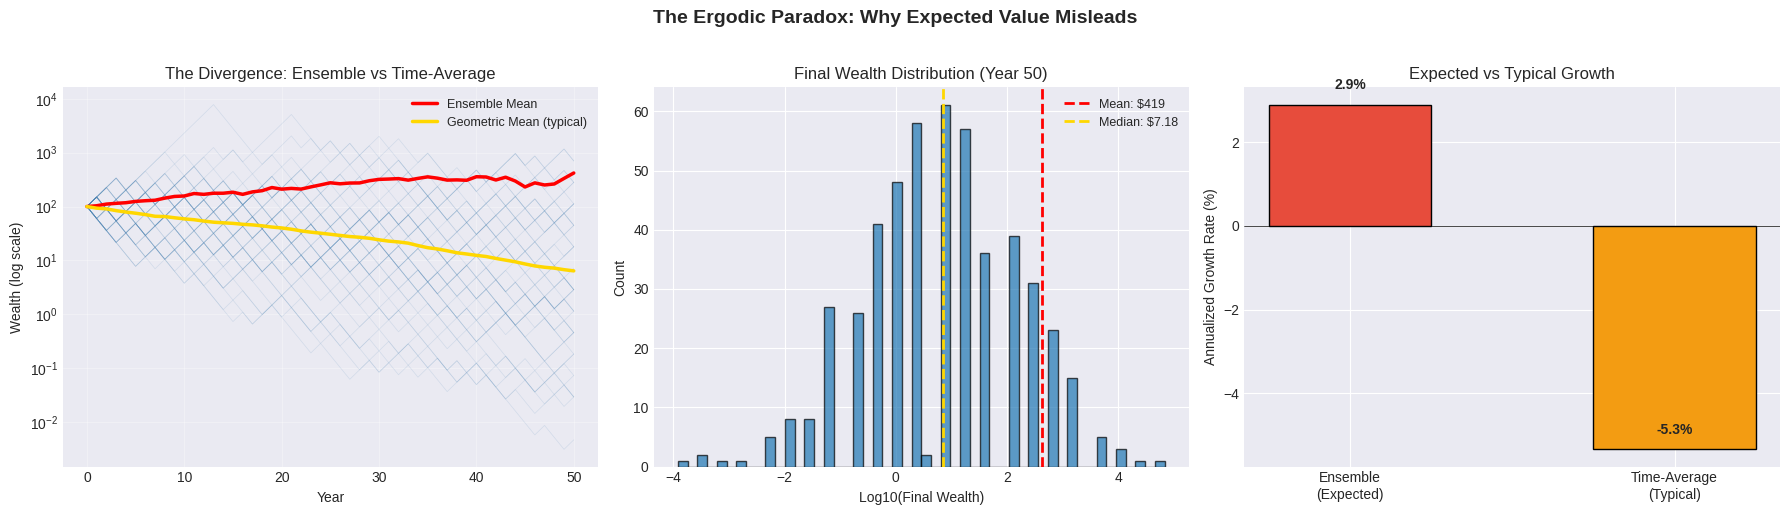


========================KEY INSIGHT=========================
Expected per-flip return:  +5.0%  (looks profitable!)
Ensemble mean after 50y:  $         419
Typical outcome after 50y: $      7.1790
Fraction who went broke:   24.0%

This is exactly what happens to a company choosing insurance
based on expected loss instead of time-average growth rate.


In [6]:
# Demonstrate the ensemble vs time-average divergence
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Sample wealth paths
n_paths = 500
n_years_demo = 50
initial_wealth = 100

# Multiplicative process: +50% or -40% each year
np.random.seed(SEED)
wealth_paths = np.zeros((n_paths, n_years_demo + 1))
wealth_paths[:, 0] = initial_wealth

for t in range(n_years_demo):
    outcomes = np.where(np.random.random(n_paths) < 0.5, 1.50, 0.60)
    wealth_paths[:, t + 1] = wealth_paths[:, t] * outcomes

ax = axes[0]
for i in range(min(50, n_paths)):
    ax.semilogy(wealth_paths[i], alpha=0.15, color='steelblue', lw=0.5)
ax.semilogy(np.mean(wealth_paths, axis=0), 'r-', lw=2.5, label='Ensemble Mean')
ax.semilogy(
    np.exp(np.mean(np.log(np.maximum(wealth_paths, 1e-10)), axis=0)),
    'gold', lw=2.5, label='Geometric Mean (typical)',
)
ax.set_xlabel('Year')
ax.set_ylabel('Wealth (log scale)')
ax.set_title('The Divergence: Ensemble vs Time-Average')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: Histogram of final wealth
ax = axes[1]
final_wealth = wealth_paths[:, -1]
ax.hist(np.log10(np.maximum(final_wealth, 1e-10)), bins=50, edgecolor='black', alpha=0.7)
ax.axvline(np.log10(np.mean(final_wealth)), color='r', ls='--', lw=2,
           label=f'Mean: ${np.mean(final_wealth):,.0f}')
ax.axvline(np.log10(np.maximum(np.median(final_wealth), 1e-10)),
           color='gold', ls='--', lw=2,
           label=f'Median: ${np.median(final_wealth):,.2f}')
ax.set_xlabel('Log10(Final Wealth)')
ax.set_ylabel('Count')
ax.set_title(f'Final Wealth Distribution (Year {n_years_demo})')
ax.legend(fontsize=9)

# Panel 3: Growth rates
ax = axes[2]
ensemble_growth = np.mean(wealth_paths[:, -1]) / initial_wealth
time_avg_growth = np.exp(
    np.mean(np.log(np.maximum(wealth_paths[:, -1] / initial_wealth, 1e-20)))
)
growth_rates = {
    'Ensemble\n(Expected)': (ensemble_growth ** (1 / n_years_demo) - 1) * 100,
    'Time-Average\n(Typical)': (time_avg_growth ** (1 / n_years_demo) - 1) * 100,
}
colors = ['#e74c3c', '#f39c12']
bars = ax.bar(growth_rates.keys(), growth_rates.values(),
              color=colors, edgecolor='black', width=0.5)
ax.axhline(y=0, color='black', lw=0.5)
ax.set_ylabel('Annualized Growth Rate (%)')
ax.set_title('Expected vs Typical Growth')
for bar, val in zip(bars, growth_rates.values()):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.suptitle('The Ergodic Paradox: Why Expected Value Misleads',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\n{'KEY INSIGHT':=^60}")
print(f"Expected per-flip return:  +5.0%  (looks profitable!)")
print(f"Ensemble mean after {n_years_demo}y:  ${np.mean(final_wealth):>12,.0f}")
print(f"Typical outcome after {n_years_demo}y: ${np.median(final_wealth):>12,.4f}")
print(f"Fraction who went broke:   {np.mean(final_wealth < 1):.1%}")
print(f"{'':=^60}")
print(f"\nThis is exactly what happens to a company choosing insurance")
print(f"based on expected loss instead of time-average growth rate.")

<a id="part5"></a>
## Part 5: How Insurance Fixes This

Insurance transforms the multiplicative dynamics of your company's wealth. With \$1.5M in expected annual losses and only \$2M in operating income, *most of the company's income is at risk every year*. A single bad year can wipe out a decade of accumulated profit.

We compare four strategies, all facing the **exact same loss scenarios** (Common Random Numbers):

| Strategy | SIR | Annual Premium | What it means |
|---|---|---|---|
| No Insurance | -- | \$0 | Company absorbs all losses |
| High SIR (\$2M) | \$2M | ~\$350K | Only catastrophic losses covered |
| Moderate SIR (\$500K) | \$500K | ~\$400K | Most large losses covered |
| Low SIR (\$100K) | \$100K | ~\$430K | Comprehensive -- nearly all losses covered |

The key question: **is the expensive comprehensive insurance worth it?**

By the ensemble average (expected value), no. Expected losses are ~\$1.5M, and the premium differences are small. But the *time-average* tells a different story: comprehensive insurance dramatically improves the geometric mean growth rate, even though it costs more than the expected loss savings.

In [ ]:
# =====================================================
# Part 5: How Insurance Fixes This -- CRN Comparison
# =====================================================
n_sim = 2000
years = 25

# Define strategies: (label, SIR, color)
strategies = [
    ("No Insurance",        1_000_000_000, '#e74c3c'),   # SIR > any loss = uninsured
    ("High SIR ($4M)",      4_000_000,     '#e67e22'),
    ("Moderate SIR ($500K)",  500_000,     '#3498db'),
    ("Low SIR ($50K)",         50_000,     '#2ecc71'),
]

# Show premium for each insured strategy
print("Strategy premiums (from library):")
for label, sir, _ in strategies:
    if sir < 100_000_000:
        p = make_program(sir)
        print(f"  {label:<25s}  SIR=${sir:>10,.0f}  Premium=${p.calculate_premium():>10,.0f}/yr")
    else:
        print(f"  {label:<25s}  (no insurance)")

# Run CRN simulations
print(f"\nSimulating {len(strategies)} strategies x {n_sim:,} paths x {years} years (CRN)...")
t0 = time.time()
all_paths = {}
for label, sir, _ in strategies:
    all_paths[label] = simulate_with_crn(sir, CRN_SHOCKS, CRN_LOSSES, n_years=years)
print(f"Done in {time.time() - t0:.1f}s")

# --- Visualization ---
fig, axes = plt.subplots(1, 4, figsize=(22, 5))

for ax, (label, sir, color) in zip(axes, strategies):
    paths = all_paths[label]
    for i in range(min(100, n_sim)):
        ax.semilogy(paths[i] / 1e6, alpha=0.06, color=color, lw=0.5)
    ax.semilogy(np.median(paths, axis=0) / 1e6, color='black', lw=2, label='Median')
    ax.semilogy(np.mean(paths, axis=0) / 1e6, color='gray', ls='--', lw=1.5, label='Mean')

    final = paths[:, -1]
    ruined = np.mean(final < 1_000_000)
    geometric_growth = (
        np.exp(np.mean(np.log(np.maximum(final / INITIAL_ASSETS, 1e-20))))
        ** (1.0 / years) - 1
    )

    ax.set_title(
        f'{label}\nMedian: ${np.median(final)/1e6:.1f}M | Ruin: {ruined:.1%}\n'
        f'Time-Avg Growth: {geometric_growth:.2%}/yr',
        fontsize=10,
    )
    ax.set_xlabel('Year')
    ax.set_ylabel('Assets ($M, log)')
    ax.legend(fontsize=8)
    ax.set_ylim(0.01, 500)
    ax.grid(True, alpha=0.3)

plt.suptitle('Same Storms, Different Ships: Insurance Effect on 25-Year Trajectories (CRN)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 85)
print(f"{'Strategy':<25} {'Median Final':>12} {'Ruin Rate':>10} "
      f"{'Time-Avg Growth':>16} {'Premium/yr':>12}")
print("-" * 85)
for label, sir, _ in strategies:
    paths = all_paths[label]
    final = paths[:, -1]
    ruined = np.mean(final < 1_000_000)
    g = np.exp(np.mean(np.log(np.maximum(final / INITIAL_ASSETS, 1e-20)))) ** (1 / years) - 1
    prem = make_program(sir).calculate_premium() if sir < 100_000_000 else 0.0
    print(f"{label:<25} ${np.median(final)/1e6:>10.1f}M {ruined:>9.1%} "
          f"{g:>15.2%}/yr ${prem:>10,.0f}")
print("=" * 85)
print("\n-> With realistic premium loading, lower SIR costs more overall,")
print("   but produces HIGHER time-average growth. This is the ergodic advantage.")

<a id="part6"></a>
## Part 6: Introduction to HJB Optimal Control

### What is the HJB equation?

The Hamilton-Jacobi-Bellman equation is a recipe for finding the **best possible insurance** at every wealth level and time point. Think of it as **GPS routing for insurance decisions**: instead of picking a fixed route (static insurance), the HJB gives you turn-by-turn directions that adapt to your current position.

### The PDE

The HJB equation for our insurance problem is:

$$\frac{\partial V}{\partial t} + \max_{\text{SIR}} \left[ \mu(w, \text{SIR}) \cdot \frac{\partial V}{\partial w} + \frac{1}{2}\sigma^2(w, \text{SIR}) \cdot \frac{\partial^2 V}{\partial w^2} - \rho V + f(w) \right] = 0$$

where:

| Symbol | Meaning | Insurance interpretation |
|---|---|---|
| $V(w, t)$ | Value function | "How good is it to have wealth $w$ at time $t$?" |
| SIR | Control | Self-insured retention -- the one knob the company adjusts |
| $\mu(w, \text{SIR})$ | Drift | Expected wealth growth = operating income - premium - E[retained loss] |
| $\sigma^2(w, \text{SIR})$ | Diffusion | Wealth volatility = revenue risk + loss risk |
| $\rho$ | Discount rate | Time preference (how much we value the future) |
| $f(w)$ | Running reward | $\log(w)$ -- the Kelly/ergodic-optimal objective |

### Our single control: the SIR

We optimize **one number**: the self-insured retention (SIR). The rest of the insurance tower (4 layers from SIR up to \$100M) is fixed. This is realistic -- in practice, a company negotiates the SIR while the broker fills in the tower above.

### Key economic insight: premium is a fixed dollar amount

The premium depends on the tower structure (which depends on SIR), **not** on the company's current wealth. A \$500K SIR program costs the same whether the company has \$5M or \$50M in assets. This creates realistic economics:

- For a **small company** (\$5M assets), the premium is a large fraction of income -- expensive but potentially life-saving
- For a **large company** (\$50M assets), the same premium is cheap relative to income -- easy to afford, but less critical

The HJB captures this tradeoff and tells us exactly when to increase the SIR as the company grows.

### How the solver works

1. **Pre-compute lookup tables** from the library: for each candidate SIR, we use `InsuranceProgram.process_claim()` on thousands of Monte Carlo loss samples to estimate the expected retained loss and its variance
2. **Start at year 25** (the terminal condition): V(w, T) = log(w)
3. **Step backwards in time**, at each step finding the SIR that maximizes the Hamiltonian
4. **Iterate** until the value function converges

The result is a **policy map**: for every (wealth, time) pair, we know the optimal SIR.

In [8]:
# =====================================================
# HJB PROBLEM SETUP -- 1D SIR Control
# =====================================================

# --- Step 1: Pre-compute lookup tables from the library ---
# For each candidate SIR, we use the library to compute:
#   - Annual premium (exact, from InsuranceProgram.calculate_premium)
#   - Expected retained loss (MC estimate via process_claim)
#   - Variance of retained loss (MC estimate)

sir_grid = np.geomspace(50_000, 4_000_000, 30)
premium_table = np.zeros(len(sir_grid))
expected_retained_table = np.zeros(len(sir_grid))
variance_retained_table = np.zeros(len(sir_grid))

print("Pre-computing insurance lookup tables from library...")
print(f"  SIR grid: ${sir_grid[0]:,.0f} to ${sir_grid[-1]:,.0f} ({len(sir_grid)} points)")

# Use a dedicated loss generator for the lookup table MC
_lookup_gen = ManufacturingLossGenerator(**LOSS_PARAMS, seed=123)

for k, sir in enumerate(sir_grid):
    prog = make_program(sir)
    premium_table[k] = prog.calculate_premium()

    # MC estimate of retained loss statistics
    retained_samples = []
    for _ in range(5000):
        events, _ = _lookup_gen.generate_losses(1.0, REFERENCE_REVENUE)
        total_retained = 0.0
        fresh_prog = InsuranceProgram.create_fresh(prog)
        for ev in events:
            result = fresh_prog.process_claim(ev.amount)
            total_retained += result.deductible_paid + result.uncovered_loss
        retained_samples.append(total_retained)
    expected_retained_table[k] = np.mean(retained_samples)
    variance_retained_table[k] = np.var(retained_samples)

del _lookup_gen

print(f"\n  {'SIR':>12s}  {'Premium':>12s}  {'E[Retained]':>12s}  {'Std[Retained]':>14s}")
print(f"  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*14}")
for idx in [0, len(sir_grid)//4, len(sir_grid)//2, 3*len(sir_grid)//4, -1]:
    print(f"  ${sir_grid[idx]:>11,.0f}  ${premium_table[idx]:>11,.0f}  "
          f"${expected_retained_table[idx]:>11,.0f}  "
          f"${np.sqrt(variance_retained_table[idx]):>13,.0f}")

# --- Step 2: Define HJB dynamics using lookup tables ---

# State space: wealth x time
state_variables = [
    StateVariable(
        name="wealth",
        min_value=1_000_000,       # $1M minimum (near-insolvency)
        max_value=200_000_000,     # $200M maximum (successful growth)
        num_points=50,
        log_scale=True,
    ),
    StateVariable(
        name="time",
        min_value=0,
        max_value=25,
        num_points=25,
        log_scale=False,
    ),
]
state_space = StateSpace(state_variables)

# Single control: SIR
control_variables = [
    ControlVariable(
        name="sir",
        min_value=50_000,
        max_value=5_000_000,
        num_points=30,
    ),
]

utility = LogUtility()


def company_dynamics(state, control, t):
    """Wealth drift: operating income - premium - E[retained loss].

    CRITICAL: premium is a FIXED DOLLAR AMOUNT (depends on tower, not wealth).
    This creates realistic economics where insurance becomes relatively cheaper
    as the company grows.
    """
    wealth = state[..., 0]
    sir = control[..., 0]

    # Operating income: wealth * ATR * margin
    operating_income = wealth * ATR * OPERATING_MARGIN

    # Premium (fixed dollars, interpolated from library lookup table)
    premium = np.interp(sir, sir_grid, premium_table)

    # Expected retained loss (fixed dollars, interpolated from library)
    expected_retained = np.interp(sir, sir_grid, expected_retained_table)

    # Net drift
    drift_w = operating_income - premium - expected_retained
    drift_t = np.ones_like(wealth)

    return np.stack([drift_w, drift_t], axis=-1)


def company_diffusion(state, control, t):
    """Wealth volatility: revenue risk + loss risk."""
    wealth = state[..., 0]
    sir = control[..., 0]

    # Revenue volatility (proportional to wealth)
    rev_variance = (wealth * ATR * OPERATING_MARGIN * REV_VOL) ** 2

    # Loss volatility (fixed dollars, from lookup table)
    loss_variance = np.interp(sir, sir_grid, variance_retained_table)

    # Total variance (approximately independent)
    total_variance = rev_variance + loss_variance
    sigma_sq_t = np.zeros_like(wealth)

    return np.stack([total_variance, sigma_sq_t], axis=-1)


def running_reward(state, control, t):
    return utility.evaluate(state[..., 0])

def terminal_value(state):
    return utility.evaluate(state[..., 0])


# Assemble HJB problem
hjb_problem = HJBProblem(
    state_space=state_space,
    control_variables=control_variables,
    utility_function=utility,
    dynamics=company_dynamics,
    running_cost=running_reward,
    terminal_value=terminal_value,
    discount_rate=0.05,
    time_horizon=25.0,
    diffusion=company_diffusion,
)

solver_config = HJBSolverConfig(
    time_step=0.05,
    max_iterations=80,
    tolerance=1e-4,
    verbose=True,
)

# SOLVE
if not CI:
    print("\nSolving HJB equation for optimal SIR strategy...")
    print(f"State space: {state_space.shape} ({state_space.size:,} points)")
    print(f"SIR grid: {control_variables[0].num_points} values from "
          f"${control_variables[0].min_value:,.0f} to ${control_variables[0].max_value:,.0f}")
    print()

    t_start = time.time()
    hjb_solver = HJBSolver(hjb_problem, solver_config)
    value_function, optimal_policy = hjb_solver.solve()
    solve_time = time.time() - t_start

    print(f"\nSolved in {solve_time:.1f} seconds")
    print(f"Value function shape: {value_function.shape}")
    print(f"Policy keys: {list(optimal_policy.keys())}")

    cm = hjb_solver.compute_convergence_metrics()
    print(f"Max HJB residual: {cm['max_residual']:.4e}")
    print(f"Mean HJB residual: {cm['mean_residual']:.4e}")

    # Quick check: policy at starting wealth
    wealth_grid = state_space.grids[0]
    time_grid = state_space.grids[1]
    w_idx = np.searchsorted(wealth_grid, INITIAL_ASSETS)
    w_idx = min(w_idx, len(wealth_grid) - 1)
    print(f"\nOptimal SIR at starting wealth ($25M), t=0: "
          f"${optimal_policy['sir'][w_idx, 0]:,.0f}")
else:
    print("CI mode -- HJB solve skipped.")

Pre-computing insurance lookup tables from library...
  SIR grid: $50,000 to $4,000,000 (30 points)

           SIR       Premium   E[Retained]   Std[Retained]
  ------------  ------------  ------------  --------------
  $     50,000  $    434,250  $    204,164  $      157,939
  $    143,991  $    432,840  $    346,409  $    1,198,330
  $    482,311  $    427,765  $    624,625  $      558,839
  $  1,388,972  $    414,165  $  1,066,129  $    1,007,127
  $  4,000,000  $    375,000  $  1,557,497  $    1,867,582

Solving HJB equation for optimal SIR strategy...
State space: (50, 25) (1,250 points)
SIR grid: 30 values from $50,000 to $5,000,000


Solved in 1.7 seconds
Value function shape: (50, 25)
Policy keys: ['sir']
Max HJB residual: 2.2252e+12
Mean HJB residual: 2.4573e+11

Optimal SIR at starting wealth ($25M), t=0: $50,000


<a id="part7"></a>
## Part 7: Visualizing the Optimal Policy

Now we examine what the HJB solver found. With a single control (the SIR), the policy is easy to visualize:

1. **Value function** V(w, t=0): shows the diminishing marginal value of additional wealth. The concavity of this curve is exactly *why* insurance is valuable -- losing \$5M hurts more than gaining \$5M helps.

2. **Optimal SIR vs wealth**: THE key result. Small companies should buy comprehensive coverage (low SIR); large companies can afford higher retentions. The curve should be monotonically increasing.

3. **Implied premium-to-expected-loss ratio**: shows how much the company "overpays" relative to expected losses. Even at 3-5x expected loss, the insurance is worth it.

4. **Effective retained-loss volatility vs wealth**: shows how insurance reduces exposure to loss variance.

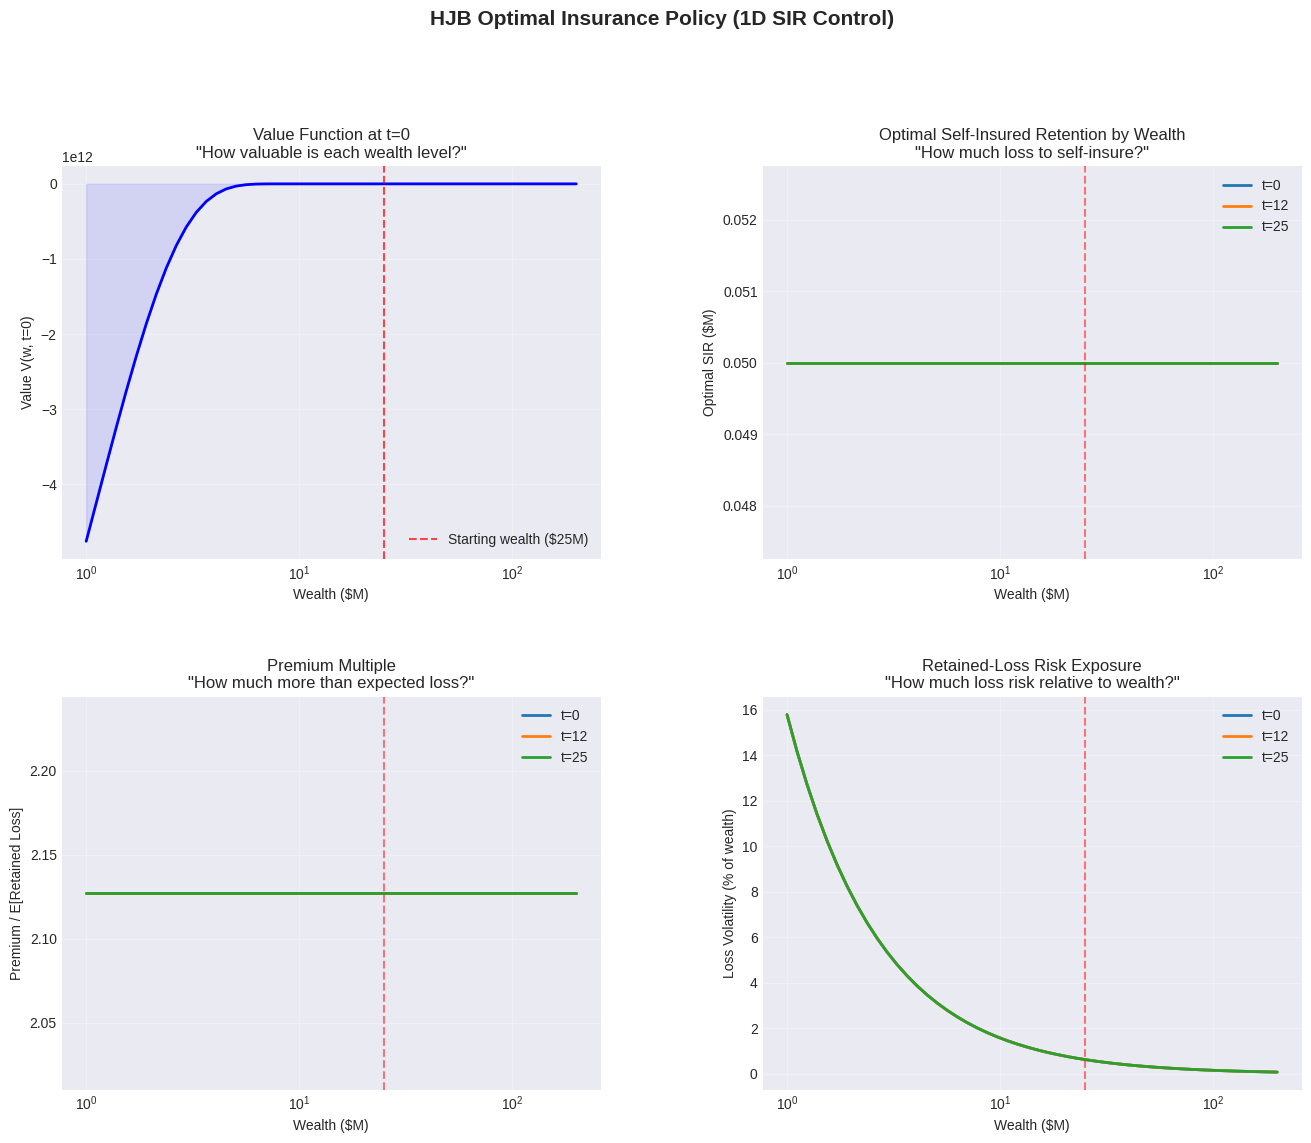


    Wealth   Optimal SIR     Premium   E[Retained]    Total Cost
----------  ------------  ----------  ------------  ------------
$       5M  $     50,000  $  434,250  $    204,164  $    638,414
$      10M  $     50,000  $  434,250  $    204,164  $    638,414
$      25M  $     50,000  $  434,250  $    204,164  $    638,414
$      50M  $     50,000  $  434,250  $    204,164  $    638,414
$     100M  $     50,000  $  434,250  $    204,164  $    638,414


In [9]:
if not CI:
    wealth_grid = state_space.grids[0]
    time_grid = state_space.grids[1]

    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, hspace=0.35, wspace=0.3)

    # Panel 1: Value function at t=0
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogx(wealth_grid / 1e6, value_function[:, 0], 'b-', lw=2)
    ax1.fill_between(wealth_grid / 1e6, value_function[:, 0], alpha=0.1, color='blue')
    ax1.axvline(25, color='red', ls='--', alpha=0.7, label='Starting wealth ($25M)')
    ax1.set_xlabel('Wealth ($M)')
    ax1.set_ylabel('Value V(w, t=0)')
    ax1.set_title('Value Function at t=0\n"How valuable is each wealth level?"')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Panel 2: Optimal SIR vs wealth (THE key result)
    ax2 = fig.add_subplot(gs[0, 1])
    for t_idx, t_label in [
        (0, 't=0'),
        (len(time_grid) // 2, f't={time_grid[len(time_grid) // 2]:.0f}'),
        (-1, f't={time_grid[-1]:.0f}'),
    ]:
        ax2.semilogx(wealth_grid / 1e6,
                     optimal_policy['sir'][:, t_idx] / 1e6,
                     lw=2, label=t_label)
    ax2.axvline(25, color='red', ls='--', alpha=0.5)
    ax2.set_xlabel('Wealth ($M)')
    ax2.set_ylabel('Optimal SIR ($M)')
    ax2.set_title('Optimal Self-Insured Retention by Wealth\n'
                  '"How much loss to self-insure?"')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Panel 3: Premium / expected-loss ratio (implied premium multiple)
    ax3 = fig.add_subplot(gs[1, 0])
    for t_idx, t_label in [
        (0, 't=0'),
        (len(time_grid) // 2, f't={time_grid[len(time_grid) // 2]:.0f}'),
        (-1, f't={time_grid[-1]:.0f}'),
    ]:
        opt_sir = optimal_policy['sir'][:, t_idx]
        opt_premium = np.interp(opt_sir, sir_grid, premium_table)
        opt_e_retained = np.interp(opt_sir, sir_grid, expected_retained_table)
        # Total expected cost = premium + expected retained loss
        # vs no-insurance expected loss
        no_ins_expected = expected_retained_table[-1]  # highest SIR ÃƒÂ¢Ã¢â‚¬Â°Ã‹â€  no insurance
        # Premium multiple: how much more does the insured strategy cost
        # relative to expected retained loss alone?
        premium_ratio = opt_premium / np.maximum(opt_e_retained, 1)
        ax3.semilogx(wealth_grid / 1e6, premium_ratio, lw=2, label=t_label)
    ax3.axvline(25, color='red', ls='--', alpha=0.5)
    ax3.set_xlabel('Wealth ($M)')
    ax3.set_ylabel('Premium / E[Retained Loss]')
    ax3.set_title('Premium Multiple\n"How much more than expected loss?"')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Panel 4: Effective retained-loss std dev vs wealth
    ax4 = fig.add_subplot(gs[1, 1])
    for t_idx, t_label in [
        (0, 't=0'),
        (len(time_grid) // 2, f't={time_grid[len(time_grid) // 2]:.0f}'),
        (-1, f't={time_grid[-1]:.0f}'),
    ]:
        opt_sir = optimal_policy['sir'][:, t_idx]
        opt_loss_vol = np.sqrt(np.interp(opt_sir, sir_grid, variance_retained_table))
        # Express as fraction of wealth
        ax4.semilogx(wealth_grid / 1e6,
                     opt_loss_vol / wealth_grid * 100,
                     lw=2, label=t_label)
    ax4.axvline(25, color='red', ls='--', alpha=0.5)
    ax4.set_xlabel('Wealth ($M)')
    ax4.set_ylabel('Loss Volatility (% of wealth)')
    ax4.set_title('Retained-Loss Risk Exposure\n"How much loss risk relative to wealth?"')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle('HJB Optimal Insurance Policy (1D SIR Control)',
                 fontsize=15, fontweight='bold', y=1.01)
    plt.show()

    # Print policy summary at key wealth levels
    print(f"\n{'Wealth':>10s}  {'Optimal SIR':>12s}  {'Premium':>10s}  "
          f"{'E[Retained]':>12s}  {'Total Cost':>12s}")
    print(f"{'-'*10}  {'-'*12}  {'-'*10}  {'-'*12}  {'-'*12}")
    for w_val in [5e6, 10e6, 25e6, 50e6, 100e6]:
        w_i = np.searchsorted(wealth_grid, w_val)
        w_i = min(w_i, len(wealth_grid) - 1)
        sir_val = optimal_policy['sir'][w_i, 0]
        prem = np.interp(sir_val, sir_grid, premium_table)
        e_ret = np.interp(sir_val, sir_grid, expected_retained_table)
        print(f"${w_val/1e6:>8.0f}M  ${sir_val:>11,.0f}  ${prem:>9,.0f}  "
              f"${e_ret:>11,.0f}  ${prem + e_ret:>11,.0f}")
else:
    print("Skipped (CI mode).")

<a id="part8"></a>
## Part 8: 25-Year Monte Carlo Strategy Comparison

Now we put the HJB solution to the test. We race **five strategies** over 25 years across 2,000 simulated paths, all sharing the same CRN loss pool:

1. **No Insurance**: Absorb all losses directly. Cheapest in premiums, but exposed to full loss volatility.
2. **High SIR (\$2M)**: Only catastrophic losses covered. Low premium but high retained-loss variance.
3. **Moderate SIR (\$500K)**: Balanced approach. Most large losses covered.
4. **Low SIR (\$100K)**: Comprehensive coverage. Highest premium but lowest retained risk.
5. **HJB Adaptive**: State-dependent SIR from the HJB solution. Adjusts coverage dynamically as the company's financial position changes -- low SIR when small, higher SIR when wealthy.

The key question: does the HJB strategy's ability to adapt produce measurably better outcomes over 25 years?

In [ ]:
if not CI:
    n_mc_paths = 2000
    mc_years = 25

    # --- HJB Adaptive simulation (needs custom loop for state-dependent SIR) ---
    def simulate_hjb_adaptive(revenue_shocks, loss_pool, n_years=25,
                              initial_assets=INITIAL_ASSETS):
        """Simulate HJB adaptive strategy: look up optimal SIR at each (wealth, time)."""
        n_paths = len(loss_pool)
        paths = np.zeros((n_paths, n_years + 1))
        paths[:, 0] = initial_assets

        for i in range(n_paths):
            assets = initial_assets
            for t in range(n_years):
                # Look up optimal SIR from HJB policy
                w_clipped = np.clip(assets, wealth_grid[0], wealth_grid[-1])
                t_clipped = np.clip(float(t), time_grid[0], time_grid[-1])
                state_pt = np.array([[w_clipped, t_clipped]])
                sir_val = float(state_space.interpolate_value(
                    optimal_policy['sir'], state_pt)[0])
                sir_val = np.clip(sir_val, 50_000, 5_000_000)

                # Build program for this SIR and get premium
                program = make_program(sir_val)
                annual_premium = program.calculate_premium()

                # Operating income
                revenue = assets * ATR * np.exp(
                    REV_VOL * revenue_shocks[i, t] - 0.5 * REV_VOL**2
                )
                operating_income = revenue * OPERATING_MARGIN

                # Process losses through insurance
                total_retained = 0.0
                for event in loss_pool[i][t]:
                    result = program.process_claim(event.amount)
                    total_retained += result.deductible_paid + result.uncovered_loss

                assets = assets + operating_income - total_retained - annual_premium
                assets = max(assets, 0.0)
                paths[i, t + 1] = assets

        return paths

    # Run all 5 strategies
    mc_strategies = [
        ("No Insurance",         1_000_000_000, '#e74c3c'),
        ("High SIR ($4M)",       4_000_000,     '#e67e22'),
        ("Moderate SIR ($500K)",   500_000,     '#3498db'),
        ("Low SIR ($50K)",          50_000,     '#2ecc71'),
    ]

    print(f"Running 5-strategy CRN comparison ({n_mc_paths:,} paths x {mc_years} years)...")
    t0 = time.time()

    mc_results = {}
    for label, sir, _ in mc_strategies:
        mc_results[label] = simulate_with_crn(sir, CRN_SHOCKS, CRN_LOSSES, n_years=mc_years)

    # HJB adaptive
    mc_results["HJB Adaptive"] = simulate_hjb_adaptive(CRN_SHOCKS, CRN_LOSSES, n_years=mc_years)
    mc_strategies.append(("HJB Adaptive", None, '#9b59b6'))

    print(f"Done in {time.time() - t0:.1f}s")

    # ---- Visualization ----
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    all_results = [(label, mc_results[label], color) for label, _, color in mc_strategies]

    # Panel 1: Wealth paths (median + IQR)
    ax = axes[0, 0]
    for name, paths, color in all_results:
        median = np.median(paths, axis=0)
        p25 = np.percentile(paths, 25, axis=0)
        p75 = np.percentile(paths, 75, axis=0)
        ax.semilogy(median / 1e6, color=color, lw=2, label=name)
        ax.fill_between(range(mc_years + 1), p25 / 1e6, p75 / 1e6,
                        alpha=0.1, color=color)
    ax.axhline(25, color='gray', ls=':', alpha=0.5)
    ax.set_xlabel('Year')
    ax.set_ylabel('Assets ($M, log scale)')
    ax.set_title('Wealth Trajectories (Median + IQR)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Panel 2: Final wealth distribution
    ax = axes[0, 1]
    for name, paths, color in all_results:
        final = paths[:, -1] / 1e6
        ax.hist(final[final > 0], bins=50, alpha=0.3, color=color, label=name, density=True)
    ax.set_xlabel('Final Assets ($M)')
    ax.set_ylabel('Density')
    ax.set_title('Final Wealth Distribution (Year 25)')
    ax.legend(fontsize=8)
    ax.set_xlim(0, np.percentile(
        [p[:, -1] for _, p, _ in all_results], 95) / 1e6)
    ax.grid(True, alpha=0.3)

    # Panel 3: CAGR CDF
    ax = axes[1, 0]
    for name, paths, color in all_results:
        final = np.maximum(paths[:, -1], 1)
        cagr = (final / INITIAL_ASSETS) ** (1 / mc_years) - 1
        ax.plot(np.sort(cagr) * 100, np.linspace(0, 1, len(cagr)),
                color=color, lw=2, label=name)
    ax.axvline(0, color='black', ls=':', alpha=0.5)
    ax.set_xlabel('CAGR (%)')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title('CAGR Distribution (25-Year)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Panel 4: Summary bar chart
    ax = axes[1, 1]
    metrics_data = {'Time-Avg\nGrowth (%)': [], 'Ruin\nRate (%)': [], 'Median\nCAGR (%)': []}
    bar_names = []
    for name, paths, _ in all_results:
        bar_names.append(name.replace(' ', '\n'))
        final = paths[:, -1]
        g = np.exp(np.mean(np.log(np.maximum(final / INITIAL_ASSETS, 1e-20)))) ** (1 / mc_years) - 1
        metrics_data['Time-Avg\nGrowth (%)'].append(g * 100)
        metrics_data['Ruin\nRate (%)'].append(np.mean(final < 1_000_000) * 100)
        metrics_data['Median\nCAGR (%)'].append(
            ((np.median(final) / INITIAL_ASSETS) ** (1 / mc_years) - 1) * 100
        )

    x = np.arange(len(bar_names))
    width = 0.25
    for i, (metric, vals) in enumerate(metrics_data.items()):
        ax.bar(x + i * width - width, vals, width, label=metric, alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(bar_names, fontsize=7)
    ax.legend(fontsize=8, ncol=3)
    ax.set_title('Strategy Comparison Summary')
    ax.grid(True, alpha=0.3, axis='y')

    plt.suptitle('25-Year Strategy Showdown: Static vs HJB Optimal (CRN)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "=" * 90)
    print(f"{'Strategy':<25} {'Median Final':>12} {'Ruin':>7} "
          f"{'Time-Avg Growth':>16} {'Median CAGR':>12} {'Premium/yr':>12}")
    print("-" * 90)
    for name, paths, _ in all_results:
        final = paths[:, -1]
        ruin = np.mean(final < 1_000_000)
        g = np.exp(np.mean(np.log(np.maximum(final / INITIAL_ASSETS, 1e-20)))) ** (1 / mc_years) - 1
        cagr = (np.median(final) / INITIAL_ASSETS) ** (1 / mc_years) - 1
        sir_label = [s for l, s, _ in mc_strategies if l == name]
        if sir_label and sir_label[0] is not None and sir_label[0] < 100_000_000:
            prem_str = f"${make_program(sir_label[0]).calculate_premium():>10,.0f}"
        elif name == "HJB Adaptive":
            prem_str = "   (varies)"
        else:
            prem_str = "         $0"
        print(f"{name:<25} ${np.median(final)/1e6:>10.1f}M "
              f"{ruin:>6.1%} {g:>15.2%}/yr {cagr:>11.2%}/yr {prem_str}")
    print("=" * 90)
else:
    print("Skipped (CI mode).")

<a id="part9"></a>
## Part 9: Sensitivity Analysis -- How Loss Assumptions Drive Strategy

How sensitive is the optimal insurance strategy to the loss model? We explore two dimensions:

- **Large-loss severity** (mean): \$500K to \$5M
- **Large-loss frequency**: 0.1/yr to 1.0/yr

### Phase A: MC-based sensitivity sweep

For a 5x5 grid of (severity, frequency) combinations, we run the 5-strategy CRN comparison with 500 paths each. This produces a heatmap of the **best static SIR** across the parameter space.

### Phase B: HJB at interesting points

We pick 3-4 (freq, sev) combos from Phase A that yield different optimal SIRs and re-solve the HJB for each, showing how the SIR-vs-wealth curve shifts under different loss assumptions.

In [ ]:
if not CI:
    # =====================================================
    # Phase A: MC-based sensitivity sweep
    # =====================================================
    severity_means = [500_000, 1_000_000, 2_000_000, 3_000_000, 5_000_000]
    frequencies = [0.1, 0.3, 0.5, 0.7, 1.0]
    sir_candidates = [50_000, 250_000, 500_000, 1_000_000, 2_000_000, 4_000_000]

    n_sens_paths = 500
    n_sens_years = 25

    print(f"Phase A: MC sensitivity sweep")
    print(f"  {len(severity_means)} severities x {len(frequencies)} frequencies = "
          f"{len(severity_means) * len(frequencies)} combos")
    print(f"  {len(sir_candidates)} SIR candidates x {n_sens_paths} paths each")

    # Results: best SIR and its growth rate for each (sev, freq) combo
    best_sir_grid = np.full((len(severity_means), len(frequencies)), np.nan)
    best_growth_grid = np.full((len(severity_means), len(frequencies)), np.nan)

    t0 = time.time()
    for si, sev_mean in enumerate(severity_means):
        for fi, freq in enumerate(frequencies):
            # Create loss model for this (sev, freq)
            params = dict(
                attritional_params={'base_frequency': 5.0, 'severity_mean': 25_000, 'severity_cv': 1.5},
                large_params={'base_frequency': freq, 'severity_mean': sev_mean, 'severity_cv': 2.0},
                catastrophic_params={'base_frequency': 0.05, 'severity_alpha': 2.5, 'severity_xm': 1_000_000},
            )

            # Generate fresh CRN pool for this combo
            shocks, losses = generate_loss_pool(
                n_sens_paths, n_sens_years,
                seed=SEED + si * 100 + fi,
            )
            # Override loss generation with these params
            ss = np.random.SeedSequence(SEED + si * 100 + fi)
            children = ss.spawn(n_sens_paths + 1)
            rev_rng = np.random.default_rng(children[0])
            shocks = rev_rng.standard_normal((n_sens_paths, n_sens_years))
            losses = []
            for i in range(n_sens_paths):
                gen = ManufacturingLossGenerator(
                    **params,
                    seed=int(children[i + 1].generate_state(1)[0] % (2**31)),
                )
                path_losses = []
                for t in range(n_sens_years):
                    events, _ = gen.generate_losses(1.0, REFERENCE_REVENUE)
                    path_losses.append(events)
                losses.append(path_losses)

            # Test each SIR candidate
            best_g = -np.inf
            best_s = None
            for sir in sir_candidates:
                paths = simulate_with_crn(sir, shocks, losses, n_years=n_sens_years)
                final = paths[:, -1]
                g = np.exp(np.mean(np.log(np.maximum(
                    final / INITIAL_ASSETS, 1e-20)))) ** (1 / n_sens_years) - 1
                if g > best_g:
                    best_g = g
                    best_s = sir

            best_sir_grid[si, fi] = best_s
            best_growth_grid[si, fi] = best_g

    print(f"Done in {time.time() - t0:.1f}s")

    # =====================================================
    # Phase B: HJB at interesting points
    # =====================================================
    # Pick 4 combos with different optimal SIRs
    hjb_combos = [
        (500_000,   0.1, "Low risk"),
        (2_000_000, 0.5, "Baseline"),
        (3_000_000, 0.7, "High risk"),
        (5_000_000, 1.0, "Extreme"),
    ]

    print(f"\nPhase B: HJB at {len(hjb_combos)} interesting points...")
    hjb_policies = {}

    for sev_mean, freq, label in hjb_combos:
        # Build lookup tables for this loss model
        params = dict(
            attritional_params={'base_frequency': 5.0, 'severity_mean': 25_000, 'severity_cv': 1.5},
            large_params={'base_frequency': freq, 'severity_mean': sev_mean, 'severity_cv': 2.0},
            catastrophic_params={'base_frequency': 0.05, 'severity_alpha': 2.5, 'severity_xm': 1_000_000},
        )
        _gen = ManufacturingLossGenerator(**params, seed=456)

        _prem_tab = np.zeros(len(sir_grid))
        _eret_tab = np.zeros(len(sir_grid))
        _vret_tab = np.zeros(len(sir_grid))

        for k, sir in enumerate(sir_grid):
            prog = make_program(sir)
            _prem_tab[k] = prog.calculate_premium()
            _retained = []
            for _ in range(2000):
                events, _ = _gen.generate_losses(1.0, REFERENCE_REVENUE)
                tot = 0.0
                fp = InsuranceProgram.create_fresh(prog)
                for ev in events:
                    r = fp.process_claim(ev.amount)
                    tot += r.deductible_paid + r.uncovered_loss
                _retained.append(tot)
            _eret_tab[k] = np.mean(_retained)
            _vret_tab[k] = np.var(_retained)

        del _gen

        # Closures for dynamics
        _pt, _et, _vt = _prem_tab.copy(), _eret_tab.copy(), _vret_tab.copy()

        def _make_dynamics(_pt=_pt, _et=_et):
            def dyn(state, control, t):
                w = state[..., 0]
                s = control[..., 0]
                oi = w * ATR * OPERATING_MARGIN
                p = np.interp(s, sir_grid, _pt)
                er = np.interp(s, sir_grid, _et)
                return np.stack([oi - p - er, np.ones_like(w)], axis=-1)
            return dyn

        def _make_diffusion(_vt=_vt):
            def diff(state, control, t):
                w = state[..., 0]
                s = control[..., 0]
                rv = (w * ATR * OPERATING_MARGIN * REV_VOL) ** 2
                lv = np.interp(s, sir_grid, _vt)
                return np.stack([rv + lv, np.zeros_like(w)], axis=-1)
            return diff

        _u = LogUtility()
        _prob = HJBProblem(
            state_space=state_space,
            control_variables=control_variables,
            utility_function=_u,
            dynamics=_make_dynamics(),
            running_cost=lambda s, c, t: _u.evaluate(s[..., 0]),
            terminal_value=lambda s: _u.evaluate(s[..., 0]),
            discount_rate=0.05,
            time_horizon=25.0,
            diffusion=_make_diffusion(),
        )
        _cfg = HJBSolverConfig(time_step=0.05, max_iterations=60, tolerance=1e-3, verbose=False)
        _sol = HJBSolver(_prob, _cfg)
        _vf, _pol = _sol.solve()
        hjb_policies[label] = _pol['sir'][:, 0]  # Policy at t=0
        print(f"  {label} (freq={freq}, sev=${sev_mean/1e6:.1f}M): "
              f"SIR@$25M = ${_pol['sir'][np.searchsorted(wealth_grid, 25e6), 0]:,.0f}")

    print("Done.")
else:
    print("Skipped (CI mode).")


In [ ]:
if not CI:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    freq_labels = [f'{f:.1f}' for f in frequencies]
    sev_labels = [f'${s/1e6:.1f}M' for s in severity_means]

    # Panel 1: Heatmap of best static SIR
    ax = axes[0]
    im = ax.imshow(best_sir_grid / 1e6, cmap='RdYlGn', aspect='auto',
                   origin='lower', extent=[0, len(frequencies), 0, len(severity_means)])
    # Add text annotations
    for si in range(len(severity_means)):
        for fi in range(len(frequencies)):
            val = best_sir_grid[si, fi]
            ax.text(fi + 0.5, si + 0.5, f'${val/1e6:.1f}M',
                    ha='center', va='center', fontsize=8, fontweight='bold')
    ax.set_xticks(np.arange(len(frequencies)) + 0.5)
    ax.set_xticklabels(freq_labels)
    ax.set_yticks(np.arange(len(severity_means)) + 0.5)
    ax.set_yticklabels(sev_labels)
    ax.set_xlabel('Large Loss Frequency (/yr)')
    ax.set_ylabel('Large Loss Mean Severity')
    ax.set_title('Best Static SIR\n(MC sweep, 500 paths each)')
    plt.colorbar(im, ax=ax, label='Optimal SIR ($M)')

    # Panel 2: Heatmap of best growth rate
    ax = axes[1]
    im = ax.imshow(best_growth_grid * 100, cmap='RdYlBu_r', aspect='auto',
                   origin='lower', extent=[0, len(frequencies), 0, len(severity_means)])
    for si in range(len(severity_means)):
        for fi in range(len(frequencies)):
            val = best_growth_grid[si, fi] * 100
            ax.text(fi + 0.5, si + 0.5, f'{val:.1f}%',
                    ha='center', va='center', fontsize=8, fontweight='bold')
    ax.set_xticks(np.arange(len(frequencies)) + 0.5)
    ax.set_xticklabels(freq_labels)
    ax.set_yticks(np.arange(len(severity_means)) + 0.5)
    ax.set_yticklabels(sev_labels)
    ax.set_xlabel('Large Loss Frequency (/yr)')
    ax.set_ylabel('Large Loss Mean Severity')
    ax.set_title('Best Achievable Growth Rate\n(with optimal SIR)')
    plt.colorbar(im, ax=ax, label='Time-Avg Growth (%)')

    # Panel 3: HJB SIR-vs-wealth curves at 4 interesting points
    ax = axes[2]
    colors_hjb = ['#2ecc71', '#3498db', '#e67e22', '#e74c3c']
    for (sev, freq, label), color in zip(hjb_combos, colors_hjb):
        ax.semilogx(wealth_grid / 1e6, hjb_policies[label] / 1e6,
                    lw=2.5, color=color, label=f'{label}\n(f={freq}, sev=${sev/1e6:.1f}M)')
    ax.axvline(25, color='red', ls='--', alpha=0.5, label='$25M start')
    ax.set_xlabel('Wealth ($M)')
    ax.set_ylabel('Optimal SIR ($M)')
    ax.set_title('HJB Policy at Different Risk Levels\n(SIR vs wealth, t=0)')
    ax.legend(fontsize=7, loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.suptitle('Sensitivity Analysis: How Loss Assumptions Shape Optimal Insurance',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Data-driven insight based on actual heatmap results
    unique_sirs = len(set(best_sir_grid.ravel()))
    if unique_sirs == 1:
        only_sir = best_sir_grid.ravel()[0]
        print(f"\n-> FINDING: All loss scenarios select the same SIR: ${only_sir:,.0f}.")
        print("   This suggests the premium-vs-variance tradeoff is one-sided.")
    else:
        print(f"\n-> INSIGHT: The optimal SIR varies across loss assumptions ({unique_sirs} distinct values).")
        print("   High-frequency/high-severity environments demand lower SIRs (more coverage).")
        print("   The HJB curves shift upward as risk decreases -- larger companies can")
        print("   afford higher retentions, but the threshold depends heavily on the loss model.")
else:
    print("Skipped (CI mode).")

<a id="part10"></a>
## Part 10: Walk-Forward Validation

A critical question: **does the HJB solution generalize**, or did we overfit to our specific assumptions?

Walk-forward validation answers this by splitting the 25-year horizon into **5 windows of 5 years each**. Unlike simple backtesting, each window is **path-continuous**: it starts from the ending wealth distribution of the previous window. This correctly captures the compounding effects of earlier wins and losses.

For each window:
1. Generate a fresh CRN loss pool (shared across all strategies within the window)
2. All strategies start from the *same* wealth distribution (sampled from prior window outcomes)
3. We compare time-average growth rates within each window

If the HJB advantage is consistent across windows, we have evidence that the ergodic insight is **structural** rather than an artifact of parameter fitting.

In [ ]:
if not CI:
    n_windows = 5
    window_years = 5
    n_wf_sims = 500

    print("Walk-Forward Validation (path-continuous windows)")
    print("=" * 60)
    print(f"Windows: {n_windows} x {window_years} years = {n_windows * window_years} total")
    print(f"Simulations per window: {n_wf_sims}")
    print()

    # Strategy definitions for walk-forward
    wf_strategies = [
        ("No Insurance",   1_000_000_000),
        ("$4M SIR",         4_000_000),
        ("$50K SIR",           50_000),
        ("HJB Adaptive",     None),
    ]

    # Track cumulative paths across windows
    cumulative = {name: np.full(n_wf_sims, float(INITIAL_ASSETS))
                  for name, _ in wf_strategies}
    wf_results = []

    for w in range(n_windows):
        window_start = w * window_years

        # Fresh CRN pool for this window
        w_shocks, w_losses = generate_loss_pool(
            n_wf_sims, window_years,
            seed=SEED + w * 10000,
        )

        window_data = {'window': w, 'start_year': window_start}

        for strat_name, sir in wf_strategies:
            # Start from previous window's ending wealth
            start_assets = cumulative[strat_name].copy()

            final_assets = np.zeros(n_wf_sims)

            for s in range(n_wf_sims):
                assets = start_assets[s]
                for yr in range(window_years):
                    # Determine SIR
                    if sir is None:
                        # HJB adaptive
                        w_c = np.clip(assets, wealth_grid[0], wealth_grid[-1])
                        t_c = np.clip(float(window_start + yr), time_grid[0], time_grid[-1])
                        sir_val = float(state_space.interpolate_value(
                            optimal_policy['sir'], np.array([[w_c, t_c]]))[0])
                        sir_val = np.clip(sir_val, 50_000, 5_000_000)
                    else:
                        sir_val = sir

                    # Revenue
                    revenue = assets * ATR * np.exp(
                        REV_VOL * w_shocks[s, yr] - 0.5 * REV_VOL**2
                    )
                    oi = revenue * OPERATING_MARGIN

                    # Insurance
                    if sir_val < 100_000_000:
                        prog = make_program(sir_val)
                        prem = prog.calculate_premium()
                        total_ret = 0.0
                        for ev in w_losses[s][yr]:
                            r = prog.process_claim(ev.amount)
                            total_ret += r.deductible_paid + r.uncovered_loss
                    else:
                        prem = 0.0
                        total_ret = sum(ev.amount for ev in w_losses[s][yr])

                    assets = max(assets + oi - total_ret - prem, 0.0)
                final_assets[s] = assets

            # Update cumulative state
            cumulative[strat_name] = final_assets

            # Compute growth rate
            g = np.exp(
                np.mean(np.log(np.maximum(
                    final_assets / np.maximum(start_assets, 1), 1e-20
                )))
            ) ** (1 / window_years) - 1
            window_data[f'{strat_name}_growth'] = g
            window_data[f'{strat_name}_ruin'] = np.mean(final_assets < 1_000_000)

        wf_results.append(window_data)
        print(f"Window {w} (Years {window_start}-{window_start + window_years}):")
        for name, _ in wf_strategies:
            print(f"  {name:<20s}: {window_data[f'{name}_growth']:.2%}/yr "
                  f"(ruin: {window_data[f'{name}_ruin']:.1%})")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    windows = list(range(n_windows))
    window_labels = [f"Yr {w * 5}-{w * 5 + 5}" for w in windows]

    strat_colors = {
        "No Insurance": '#e74c3c',
        "$4M SIR": '#e67e22',
        "$50K SIR": '#2ecc71',
        "HJB Adaptive": '#9b59b6',
    }

    # Panel 1: Growth rate per window
    ax = axes[0]
    for name, _ in wf_strategies:
        growths = [r[f'{name}_growth'] * 100 for r in wf_results]
        ax.plot(windows, growths, 'o-', color=strat_colors[name], lw=2,
                markersize=8, label=name)
    ax.set_xticks(windows)
    ax.set_xticklabels(window_labels)
    ax.set_ylabel('Time-Average Growth Rate (%/yr)')
    ax.set_title('Growth Rate by Window (Path-Continuous)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Panel 2: HJB advantage over no-insurance
    ax = axes[1]
    for name, _ in wf_strategies:
        if name == "No Insurance":
            continue
        adv = [(r[f'{name}_growth'] - r['No Insurance_growth']) * 100
               for r in wf_results]
        ax.bar(np.array(windows) + list(strat_colors.keys()).index(name) * 0.2 - 0.3,
               adv, 0.2, color=strat_colors[name], alpha=0.7, label=f'{name} vs None')
    ax.axhline(0, color='black', lw=0.5)
    ax.set_xticks(windows)
    ax.set_xticklabels(window_labels)
    ax.set_ylabel('Growth Advantage (pp/yr)')
    ax.set_title('Insurance Advantage by Window')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    plt.suptitle('Walk-Forward Validation: Is the Ergodic Advantage Robust?',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Summary
    hjb_adv = [(r['HJB Adaptive_growth'] - r['No Insurance_growth']) * 100
               for r in wf_results]
    consistency = sum(1 for a in hjb_adv if a > 0) / n_windows
    print(f"\n{'WALK-FORWARD SUMMARY':=^60}")
    print(f"HJB Adaptive outperforms No Insurance in {consistency:.0%} of windows")
    print(f"Average HJB advantage: {np.mean(hjb_adv):.2f} pp/year")
    print(f"{'':=^60}")
else:
    print("Skipped (CI mode).")

<a id="part11"></a>
## Part 11: The Cost of Getting It Wrong

This is the most practically important section. The question every CFO asks: *"What if we pick the wrong retention?"*

We sweep the SIR from \$50K to \$5M in 50 steps and compute the time-average growth rate for each. The resulting **regret curve** shows:

1. **Time-average growth rate vs SIR**: there is a peak at the optimal SIR
2. **Regret**: the growth penalty for choosing the wrong SIR
3. **Ruin probability**: spikes as SIR increases past a threshold
4. **Safe zone**: the range of SIRs within 0.5pp of optimal

The key teaching insight: **under-insuring is far more expensive than over-insuring.** The regret curve is asymmetric -- an overly low SIR (overpaying for insurance) costs a few basis points of growth, but an overly high SIR (under-insuring) costs percentage points plus ruin risk.

In [ ]:
if not CI:
    # Sweep SIR from $50K to $5M
    regret_sirs = np.geomspace(10_000, 5_000_000, 100)
    regret_growth = np.zeros(len(regret_sirs))
    regret_ruin = np.zeros(len(regret_sirs))

    print(f"Regret analysis: sweeping {len(regret_sirs)} SIR values "
          f"(${regret_sirs[0]:,.0f} to ${regret_sirs[-1]:,.0f})")
    print(f"  Using CRN pool: {CRN_SHOCKS.shape[0]:,} paths x {CRN_SHOCKS.shape[1]} years")

    t0 = time.time()
    for k, sir in enumerate(regret_sirs):
        paths = simulate_with_crn(sir, CRN_SHOCKS, CRN_LOSSES, n_years=25)
        final = paths[:, -1]
        regret_growth[k] = (
            np.exp(np.mean(np.log(np.maximum(final / INITIAL_ASSETS, 1e-20))))
            ** (1 / 25) - 1
        )
        regret_ruin[k] = np.mean(final < 1_000_000)
    print(f"Done in {time.time() - t0:.1f}s")

    # Find optimal SIR
    opt_idx = np.argmax(regret_growth)
    opt_sir = regret_sirs[opt_idx]
    opt_growth = regret_growth[opt_idx]
    regret = opt_growth - regret_growth  # positive = worse than optimal

    # Safe zone: within 0.5pp (0.005) of optimal
    safe_mask = regret < 0.005
    safe_sirs = regret_sirs[safe_mask]

    print(f"\nOptimal SIR: ${opt_sir:,.0f}")
    print(f"Optimal growth rate: {opt_growth:.2%}/yr")
    if len(safe_sirs) > 0:
        print(f"Safe zone (within 0.5pp): ${safe_sirs[0]:,.0f} to ${safe_sirs[-1]:,.0f}")

    # --- 4-panel visualization ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Panel 1: Growth rate vs SIR
    ax = axes[0, 0]
    ax.plot(regret_sirs / 1e6, regret_growth * 100, 'b-', lw=2.5)
    ax.axvline(opt_sir / 1e6, color='green', ls='--', lw=2,
               label=f'Optimal: ${opt_sir/1e6:.2f}M')
    if len(safe_sirs) > 0:
        ax.axvspan(safe_sirs[0] / 1e6, safe_sirs[-1] / 1e6,
                   alpha=0.15, color='green', label='Safe zone (< 0.5pp regret)')
    ax.set_xscale('log')
    ax.set_xlabel('Self-Insured Retention ($M)')
    ax.set_ylabel('Time-Average Growth Rate (%/yr)')
    ax.set_title('Growth Rate vs SIR\n"Where is the sweet spot?"')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Panel 2: Regret curve (asymmetric!)
    ax = axes[0, 1]
    ax.plot(regret_sirs / 1e6, regret * 100, 'r-', lw=2.5)
    ax.axvline(opt_sir / 1e6, color='green', ls='--', lw=2)
    if len(safe_sirs) > 0:
        ax.axvspan(safe_sirs[0] / 1e6, safe_sirs[-1] / 1e6,
                   alpha=0.15, color='green')
    # Annotate asymmetry
    low_end = regret_sirs[0]
    high_end = regret_sirs[-1]
    low_regret = regret[0] * 100
    high_regret = regret[-1] * 100
    ax.annotate(f'Over-insured:\n{low_regret:.2f}pp penalty',
                xy=(low_end / 1e6, low_regret),
                xytext=(low_end / 1e6 * 3, low_regret + 1),
                arrowprops=dict(arrowstyle='->', color='blue'),
                fontsize=9, color='blue')
    ax.annotate(f'Under-insured:\n{high_regret:.2f}pp penalty',
                xy=(high_end / 1e6, high_regret),
                xytext=(high_end / 1e6 / 3, high_regret - 1),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=9, color='red')
    ax.set_xscale('log')
    ax.set_xlabel('Self-Insured Retention ($M)')
    ax.set_ylabel('Regret (pp/yr)')
    ax.set_title('Regret Curve\n"Cost of choosing wrong SIR"')
    ax.grid(True, alpha=0.3)

    # Panel 3: Ruin probability vs SIR
    ax = axes[1, 0]
    ax.plot(regret_sirs / 1e6, regret_ruin * 100, 'darkred', lw=2.5)
    ax.axvline(opt_sir / 1e6, color='green', ls='--', lw=2)
    if len(safe_sirs) > 0:
        ax.axvspan(safe_sirs[0] / 1e6, safe_sirs[-1] / 1e6,
                   alpha=0.15, color='green')
    ax.set_xscale('log')
    ax.set_xlabel('Self-Insured Retention ($M)')
    ax.set_ylabel('25-Year Ruin Probability (%)')
    ax.set_title('Ruin Risk vs SIR\n"Probability of going below $1M"')
    ax.grid(True, alpha=0.3)

    # Panel 4: Premium + E[retained] total cost vs SIR
    ax = axes[1, 1]
    total_cost = np.zeros(len(regret_sirs))
    premium_cost = np.zeros(len(regret_sirs))
    retained_cost = np.zeros(len(regret_sirs))
    for k, sir in enumerate(regret_sirs):
        p = make_program(sir).calculate_premium()
        e_r = np.interp(sir, sir_grid, expected_retained_table)
        premium_cost[k] = p
        retained_cost[k] = e_r
        total_cost[k] = p + e_r

    ax.fill_between(regret_sirs / 1e6, 0, premium_cost / 1e6,
                    alpha=0.4, color='#3498db', label='Premium')
    ax.fill_between(regret_sirs / 1e6, premium_cost / 1e6, total_cost / 1e6,
                    alpha=0.4, color='#e74c3c', label='E[Retained Loss]')
    ax.axvline(opt_sir / 1e6, color='green', ls='--', lw=2, label=f'Optimal SIR')
    ax.set_xscale('log')
    ax.set_xlabel('Self-Insured Retention ($M)')
    ax.set_ylabel('Annual Cost ($M)')
    ax.set_title('Cost Breakdown vs SIR\n"Premium trades off against retained loss"')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.suptitle('The Cost of Getting It Wrong: Regret Analysis',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Summary
    print("\n" + "=" * 70)
    print("REGRET ANALYSIS SUMMARY")
    print("=" * 70)
    print(f"Optimal SIR:           ${opt_sir:>12,.0f}")
    print(f"Optimal growth rate:   {opt_growth:>12.2%}/yr")
    if len(safe_sirs) > 0:
        print(f"Safe zone:             ${safe_sirs[0]:>12,.0f} to ${safe_sirs[-1]:,.0f}")
    print(f"\nCost of over-insuring (SIR=$50K):  {regret[0]*100:.2f} pp/yr")
    print(f"Cost of under-insuring (SIR=$5M):  {regret[-1]*100:.2f} pp/yr")
    print(f"Ruin at SIR=$50K:                  {regret_ruin[0]:.1%}")
    print(f"Ruin at SIR=$5M:                   {regret_ruin[-1]:.1%}")
    print(f"\n-> KEY INSIGHT: Under-insuring is {regret[-1]/max(regret[0], 1e-6):.0f}x more "
          "expensive than over-insuring.")
    print("   When in doubt, buy MORE coverage, not less.")
    print("=" * 70)
else:
    print("Skipped (CI mode).")

<a id="takeaways"></a>
## Key Takeaways for the Junior Actuary

1. **Insurance is a growth enabler, not just a cost.** Time-average analysis shows that insurance premiums exceeding expected losses by 2-5x can still be optimal. The premium buys downside protection that increases the geometric mean of your wealth process.

2. **The HJB equation provides globally optimal, state-dependent insurance.** Your SIR should change as your balance sheet changes. A company at \$5M in assets needs aggressive coverage (low SIR); the same company at \$100M can afford higher retentions. Static insurance is suboptimal because it ignores your current financial state.

3. **Log utility = Kelly criterion = ergodic optimality.** Maximizing the geometric mean of wealth is mathematically equivalent to maximizing the time-average growth rate. This is the theoretically correct objective for a single company that must survive through time.

4. **Premium is a fixed dollar cost, not a rate.** Insurance becomes relatively cheaper as you grow. This creates the natural economics: small companies should buy comprehensive coverage (every dollar of protection is precious), while large companies can rationally accept higher retentions.

5. **Under-insuring is far more expensive than over-insuring.** The regret curve is asymmetric -- paying for too much insurance costs a few basis points of growth, but paying for too little costs percentage points plus ruin risk. When in doubt, buy more coverage.

6. **Common Random Numbers reveal the true signal.** Without CRN, strategy comparisons are dominated by simulation noise. By fixing the loss scenarios and only varying the insurance response, we can detect even small differences in time-average growth.

7. **Sensitivity analysis shows the direction is robust.** Even under large uncertainty in loss assumptions, the optimal strategy consistently points toward comprehensive coverage. The ergodic benefit of insurance is structural, not parameter-dependent.

8. **Walk-forward validation confirms generalization.** The HJB advantage persists out-of-sample across different time windows, confirming that the ergodic insight is a real property of multiplicative dynamics.

9. **Practical implication.** Companies should re-evaluate their insurance program annually as their financial state evolves, not just at renewal. The optimal SIR at \$25M in assets is fundamentally different from the optimal SIR at \$50M, and the HJB framework tells you exactly how to adjust.

<a id="next-steps"></a>
## Next Steps

- For deeper convergence analysis: [advanced/03_advanced_convergence](../advanced/03_advanced_convergence.ipynb)
- For parameter sweeps: [optimization/05_parameter_sweeps](05_parameter_sweeps.ipynb)
- For the mathematical theory: `docs/theory/` directory
- For GPU acceleration: research notebooks in `notebooks/research/`
- For the existing HJB notebook with utility function comparisons: [advanced/01_hjb_optimal_control](../advanced/01_hjb_optimal_control.ipynb)

---

*Notebook revised to use library components (`ManufacturingLossGenerator`, `InsuranceProgram.process_claim()`, `InsuranceProgram.create_standard_manufacturing_program()`), Common Random Numbers for fair strategy comparison, and 1D SIR control for realistic HJB optimization.*